<a href="https://colab.research.google.com/github/jamshaid2610/analysis-jcl/blob/main/Batting%20Scorecard/Batting_Performance_Analysis_(Autoencoder).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Batting Scorecard Analysis/EDA and Data Cleaning/Batsman Performance Metrics.csv')
scaled_df = pd.read_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Batting Scorecard Analysis/EDA and Data Cleaning/Batsman Performance Metrics (Scaled).csv')

# Autoencoder for Dimension Reduction

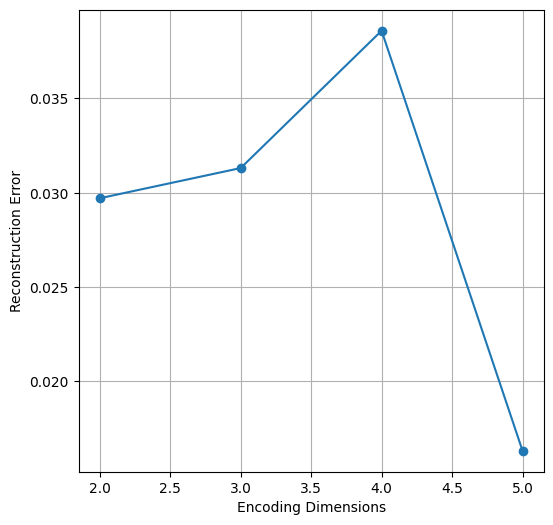

In [ ]:
from keras.layers import Input, Dense, LeakyReLU
from keras.models import Model
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test = train_test_split(scaled_df, test_size=0.2, random_state=42)

encoding_dims = range(2,6)
reconstruction_errors = []

# Iterate through different encoding dimensions for the autoencoder
for dim in encoding_dims:
  input_dim = scaled_df.shape[1]
  # Define the autoencoder structure
  input_layer = Input(shape=(input_dim,))
  encoder = Dense(dim)(input_layer)
  encoder = LeakyReLU()(encoder)
  decoder = Dense(input_dim, activation='linear')(encoder)
  autoencoder = Model(input_layer, decoder)

  # Compile the autoencoder model
  autoencoder.compile(optimizer='adam', loss='mean_squared_error')
  # Train the autoencoder
  autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test), verbose=0)
  # Evaluate reconstruction error on test set
  reconstruction_error = autoencoder.evaluate(X_test, X_test, verbose=0)
  reconstruction_errors.append(reconstruction_error)

# Plot the reconstruction error for each encoding dimension
plt.figure(figsize=(6, 6))
plt.plot(encoding_dims, reconstruction_errors, marker='o')
plt.xlabel('Encoding Dimensions')
plt.ylabel('Reconstruction Error')
# plt.title('Reconstruction Error vs. Encoding Dimensions')
plt.grid(True)
plt.show()

In [ ]:
# Identify the optimal number of encoding dimensions
optimal_dim = encoding_dims[np.argmin(reconstruction_errors)]
print(optimal_dim)

5


In [ ]:
n_features = scaled_df.shape[1]
n_features

7

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the final autoencoder
input_layer = Input(shape=(n_features,))
encoder = Dense(n_features-1)(input_layer)
encoder = LeakyReLU()(encoder)
encoder = Dense(n_features-1)(encoder)
encoder = LeakyReLU()(encoder)
encoder = Dense(optimal_dim)(encoder)

decoder = Dense(n_features+1)(encoder)
decoder = LeakyReLU()(decoder)
decoder = Dense(n_features+1)(decoder)
decoder = LeakyReLU()(decoder)
decoder = Dense(n_features, activation='linear')(decoder)
# Use the encoder part of the model to transform the data
autoencoder = Model(inputs=input_layer, outputs=decoder)
encoder = Model(inputs=input_layer, outputs=encoder)
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')
# Add callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
# Train the autoencoder
autoencoder.fit(scaled_df, scaled_df, epochs=100, batch_size=15, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

encoded_data = encoder.predict(scaled_df)
# Create a DataFrame for the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=[f'ED {i+1}' for i in range(optimal_dim)])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2765 - val_loss: 0.1969 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2218 - val_loss: 0.1724 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1884 - val_loss: 0.1455 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1706 - val_loss: 0.1110 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1243 - val_loss: 0.0704 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0752 - val_loss: 0.0408 - learning_rate: 0.0010
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0445 - val_loss: 0.0325 - learning_rate: 0.0010
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0324 - val_loss: 0.0230 - learning_rate: 0.0010
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0250 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 10/100
15/15

In [ ]:
encoded_df.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Batting Scorecard Analysis/Analysis (Autoencoders)/Batsman Performance Metrics (Encoded).csv', index=False)

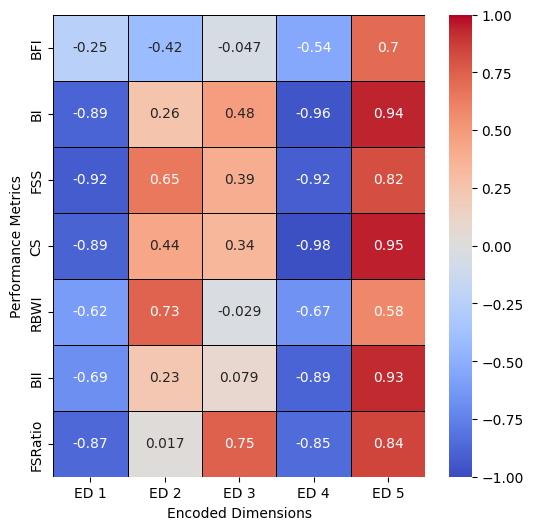

In [ ]:
correlation_matrix = scaled_df.corrwith(encoded_df, axis=0).to_frame().transpose()

# Transpose the correlation matrix for better readability
correlation_matrix = pd.concat([scaled_df.corrwith(encoded_df[col]) for col in encoded_df.columns], axis=1)
correlation_matrix.columns = encoded_df.columns

plt.figure(figsize=(6, 6))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0, linecolor='black', linewidths=0.5)


# plt.title('Correlation Between Scaled Performance Metrics and Encoded Dimensions')
plt.xlabel('Encoded Dimensions')
plt.ylabel('Performance Metrics')

plt.show()



# KMeans Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

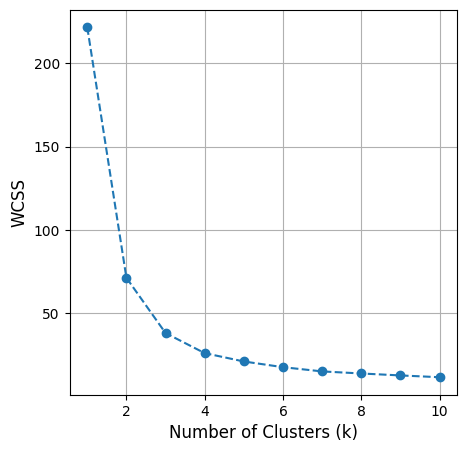

In [ ]:
from sklearn.cluster import KMeans

wcss = []
k_values = range(1,11)

for k in k_values:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(encoded_df)
  wcss.append(kmeans.inertia_)

plt.figure(figsize=(5, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
# plt.title('Optimal Number of Clusters', fontsize=14)
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

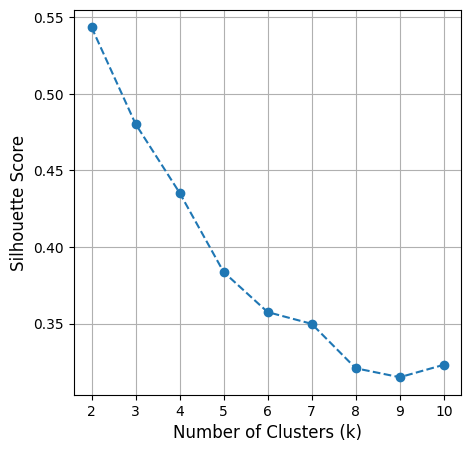

In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in k_values[1:]:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(encoded_df)
  score = silhouette_score(encoded_df, kmeans.labels_)
  sil_scores.append(score)

plt.figure(figsize=(5, 5))
plt.plot(k_values[1:], sil_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
# plt.title('Optimal Number of Clusters', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(encoded_df)

encoded_df2 = encoded_df.copy()
encoded_df2['KCluster'] = clusters
df['KCluster'] = clusters
scaled_df['KCluster'] = clusters



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


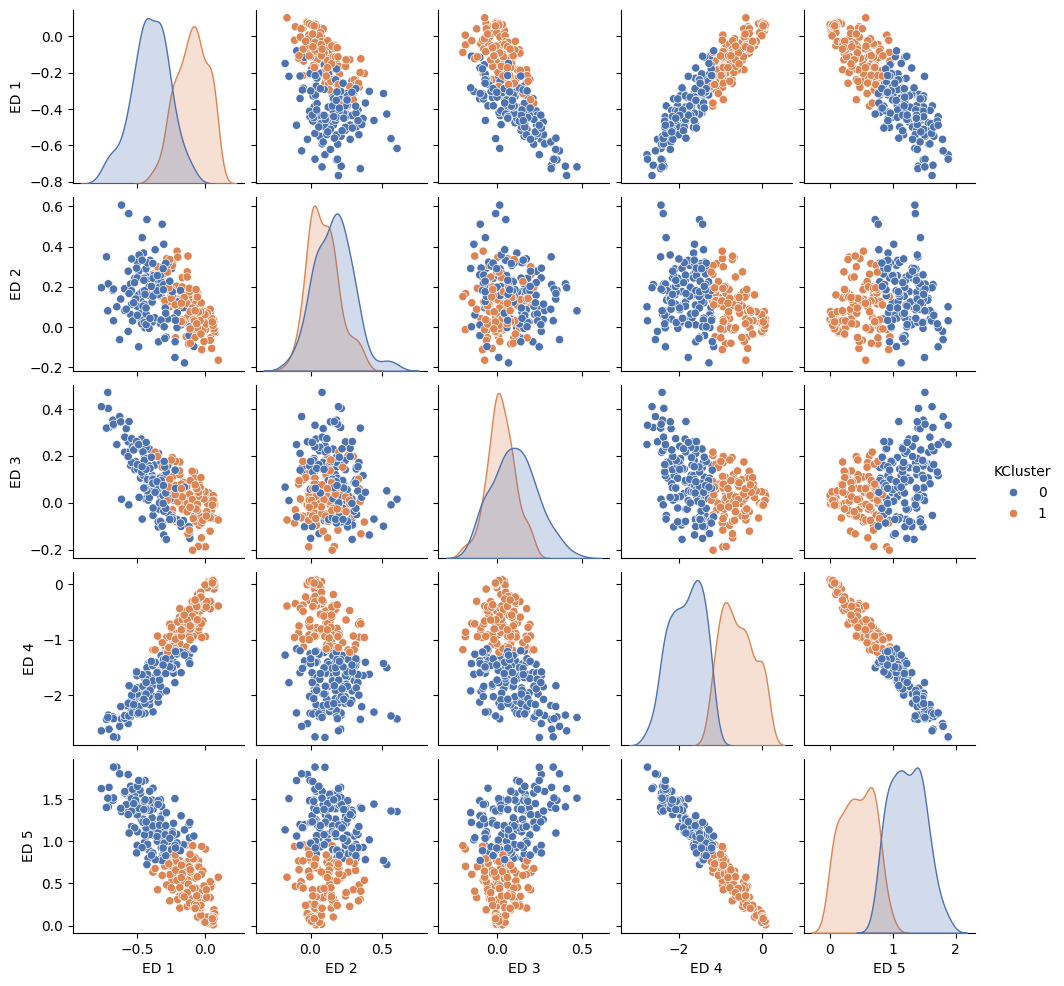

In [ ]:
sns.pairplot(encoded_df2, hue='KCluster', palette='deep', diag_kind='kde', height=2, aspect=1)
# plt.suptitle('Pairplot of Encoded Dimensions', y=1.02)
plt.show()

In [ ]:
kcluster_means_summary = scaled_df.groupby('KCluster').mean()
kcluster_means_summary.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Batting Scorecard Analysis/Analysis (Autoencoders)/KMeans Cluster Summary (Autoencoder).csv')
kcluster_means_summary

,BFI,BI,FSS,CS,RBWI,BII,FSRatio
KCluster,,,,,,,
0,0.551166,0.672221,0.571371,0.686939,0.460749,0.703951,0.422253
1,0.360806,0.273229,0.257160,0.259802,0.302539,0.263472,0.107383


In [ ]:
kcluster_descriptive = scaled_df.groupby('KCluster').describe()
kcluster_descriptive.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Batting Scorecard Analysis/Analysis (Autoencoders)/KMeans Cluster Descriptive (Autoencoder).csv')
kcluster_descriptive

BFI                                                              \
          count      mean       std       min       25%       50%       75%   
KCluster                                                                      
0         147.0  0.551166  0.169095  0.150788  0.436133  0.563777  0.670110   
1         122.0  0.360806  0.167118  0.000000  0.257317  0.345137  0.448824   

                       BI            ...       BII           FSRatio  \
               max  count      mean  ...       75%       max   count   
KCluster                             ...                               
0         1.000000  147.0  0.672221  ...  0.839045  1.000000   147.0   
1         0.892334  122.0  0.273229  ...  0.401890  0.847997   122.0   

                                                                                
              mean       std       min       25%       50%       75%       max  
KCluster                                                                        
0         0.422253  0.209790  0.066722  0.261127  0.386198  0.547709  1.000000  
1         0.107383  0.083063  0.000000  0.044592  0.088744  0.175764  0.344895  

[2 rows x 56 columns]

In [ ]:
#The weights of derived performance metrics can be changed according to what the user is looking for in the cluster data.
weights = {
    'BFI': 0.10,
    'BI': 1,
    'FSS': 1,
    'CS': 1,
    'RBWI': 0.10,
    'FSRatio': 0.5,
    'BII': 1
}

#The clusters value will be changed according to which cluster has the higher means
cluster_0_data = scaled_df[clusters == 0].copy()


cluster_0_data['Composite Score'] = (
    cluster_0_data['BFI'] * weights['BFI'] +
    cluster_0_data['BI'] * weights['BI'] +
    cluster_0_data['BII'] * weights['BII'] +
    cluster_0_data['CS'] * weights['CS'] +
    cluster_0_data['FSS'] * weights['FSS'] +
    cluster_0_data['RBWI'] * weights['RBWI'] +
    cluster_0_data['FSRatio'] * weights['FSRatio']
)


cluster_0_data['Batsman'] = df[clusters == 0]['Player'].values
cluster_0_data['Team'] = df[clusters == 0]['Team'].values


ranked_cluster_0 = cluster_0_data[['Batsman', 'Team', 'Composite Score']].sort_values(by='Composite Score', ascending=False)


ranked_cluster_0


,Batsman,Team,Composite Score
57,C Dyer,Littletown CC Under 13,4.077043
172,Oliver Jackson,Castle Eden CC Under 13,4.066798
33,Alfie Blenkiron,Bishop Auckland CC Under 13,3.977343
130,C McCarthy,Dawdon Welfare CC Under 13,3.951857
39,Manas Chengalavala,Durham City CC Under 13 Blue,3.930869
...,...,...,...
265,Bradley Reay,Burnhope CC Under 13,2.126116
223,Dan Bell,Beamish and E. Stanley CC Under 13,2.073619
118,Eesa Irfan,South Shields CC Under 13 B,2.058309
95,W Connor,Gateshead Fell CC Under 13 A,2.016100


In [ ]:
ranked_cluster_0['Rank'] = range(1, len(ranked_cluster_0) + 1)
ranked_cluster_0 = ranked_cluster_0[['Rank', 'Batsman', 'Team', 'Composite Score']]
ranked_cluster_0


,Rank,Batsman,Team,Composite Score
57,1,C Dyer,Littletown CC Under 13,4.077043
172,2,Oliver Jackson,Castle Eden CC Under 13,4.066798
33,3,Alfie Blenkiron,Bishop Auckland CC Under 13,3.977343
130,4,C McCarthy,Dawdon Welfare CC Under 13,3.951857
39,5,Manas Chengalavala,Durham City CC Under 13 Blue,3.930869
...,...,...,...,...
265,143,Bradley Reay,Burnhope CC Under 13,2.126116
223,144,Dan Bell,Beamish and E. Stanley CC Under 13,2.073619
118,145,Eesa Irfan,South Shields CC Under 13 B,2.058309
95,146,W Connor,Gateshead Fell CC Under 13 A,2.016100


In [ ]:
ranked_cluster_0.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Batting Scorecard Analysis/Analysis (Autoencoders)/Player Ranking KMeans Cluster 0 (Autoencoder).csv', index=False)

In [ ]:
scaled_df2 = scaled_df.copy()
scaled_df2 = scaled_df2.drop(columns=['KCluster'])

# Hierarchical Clustering

Performs hierarchical clustering on the encoded data and assigns hierarchical cluster labels to the dataset.

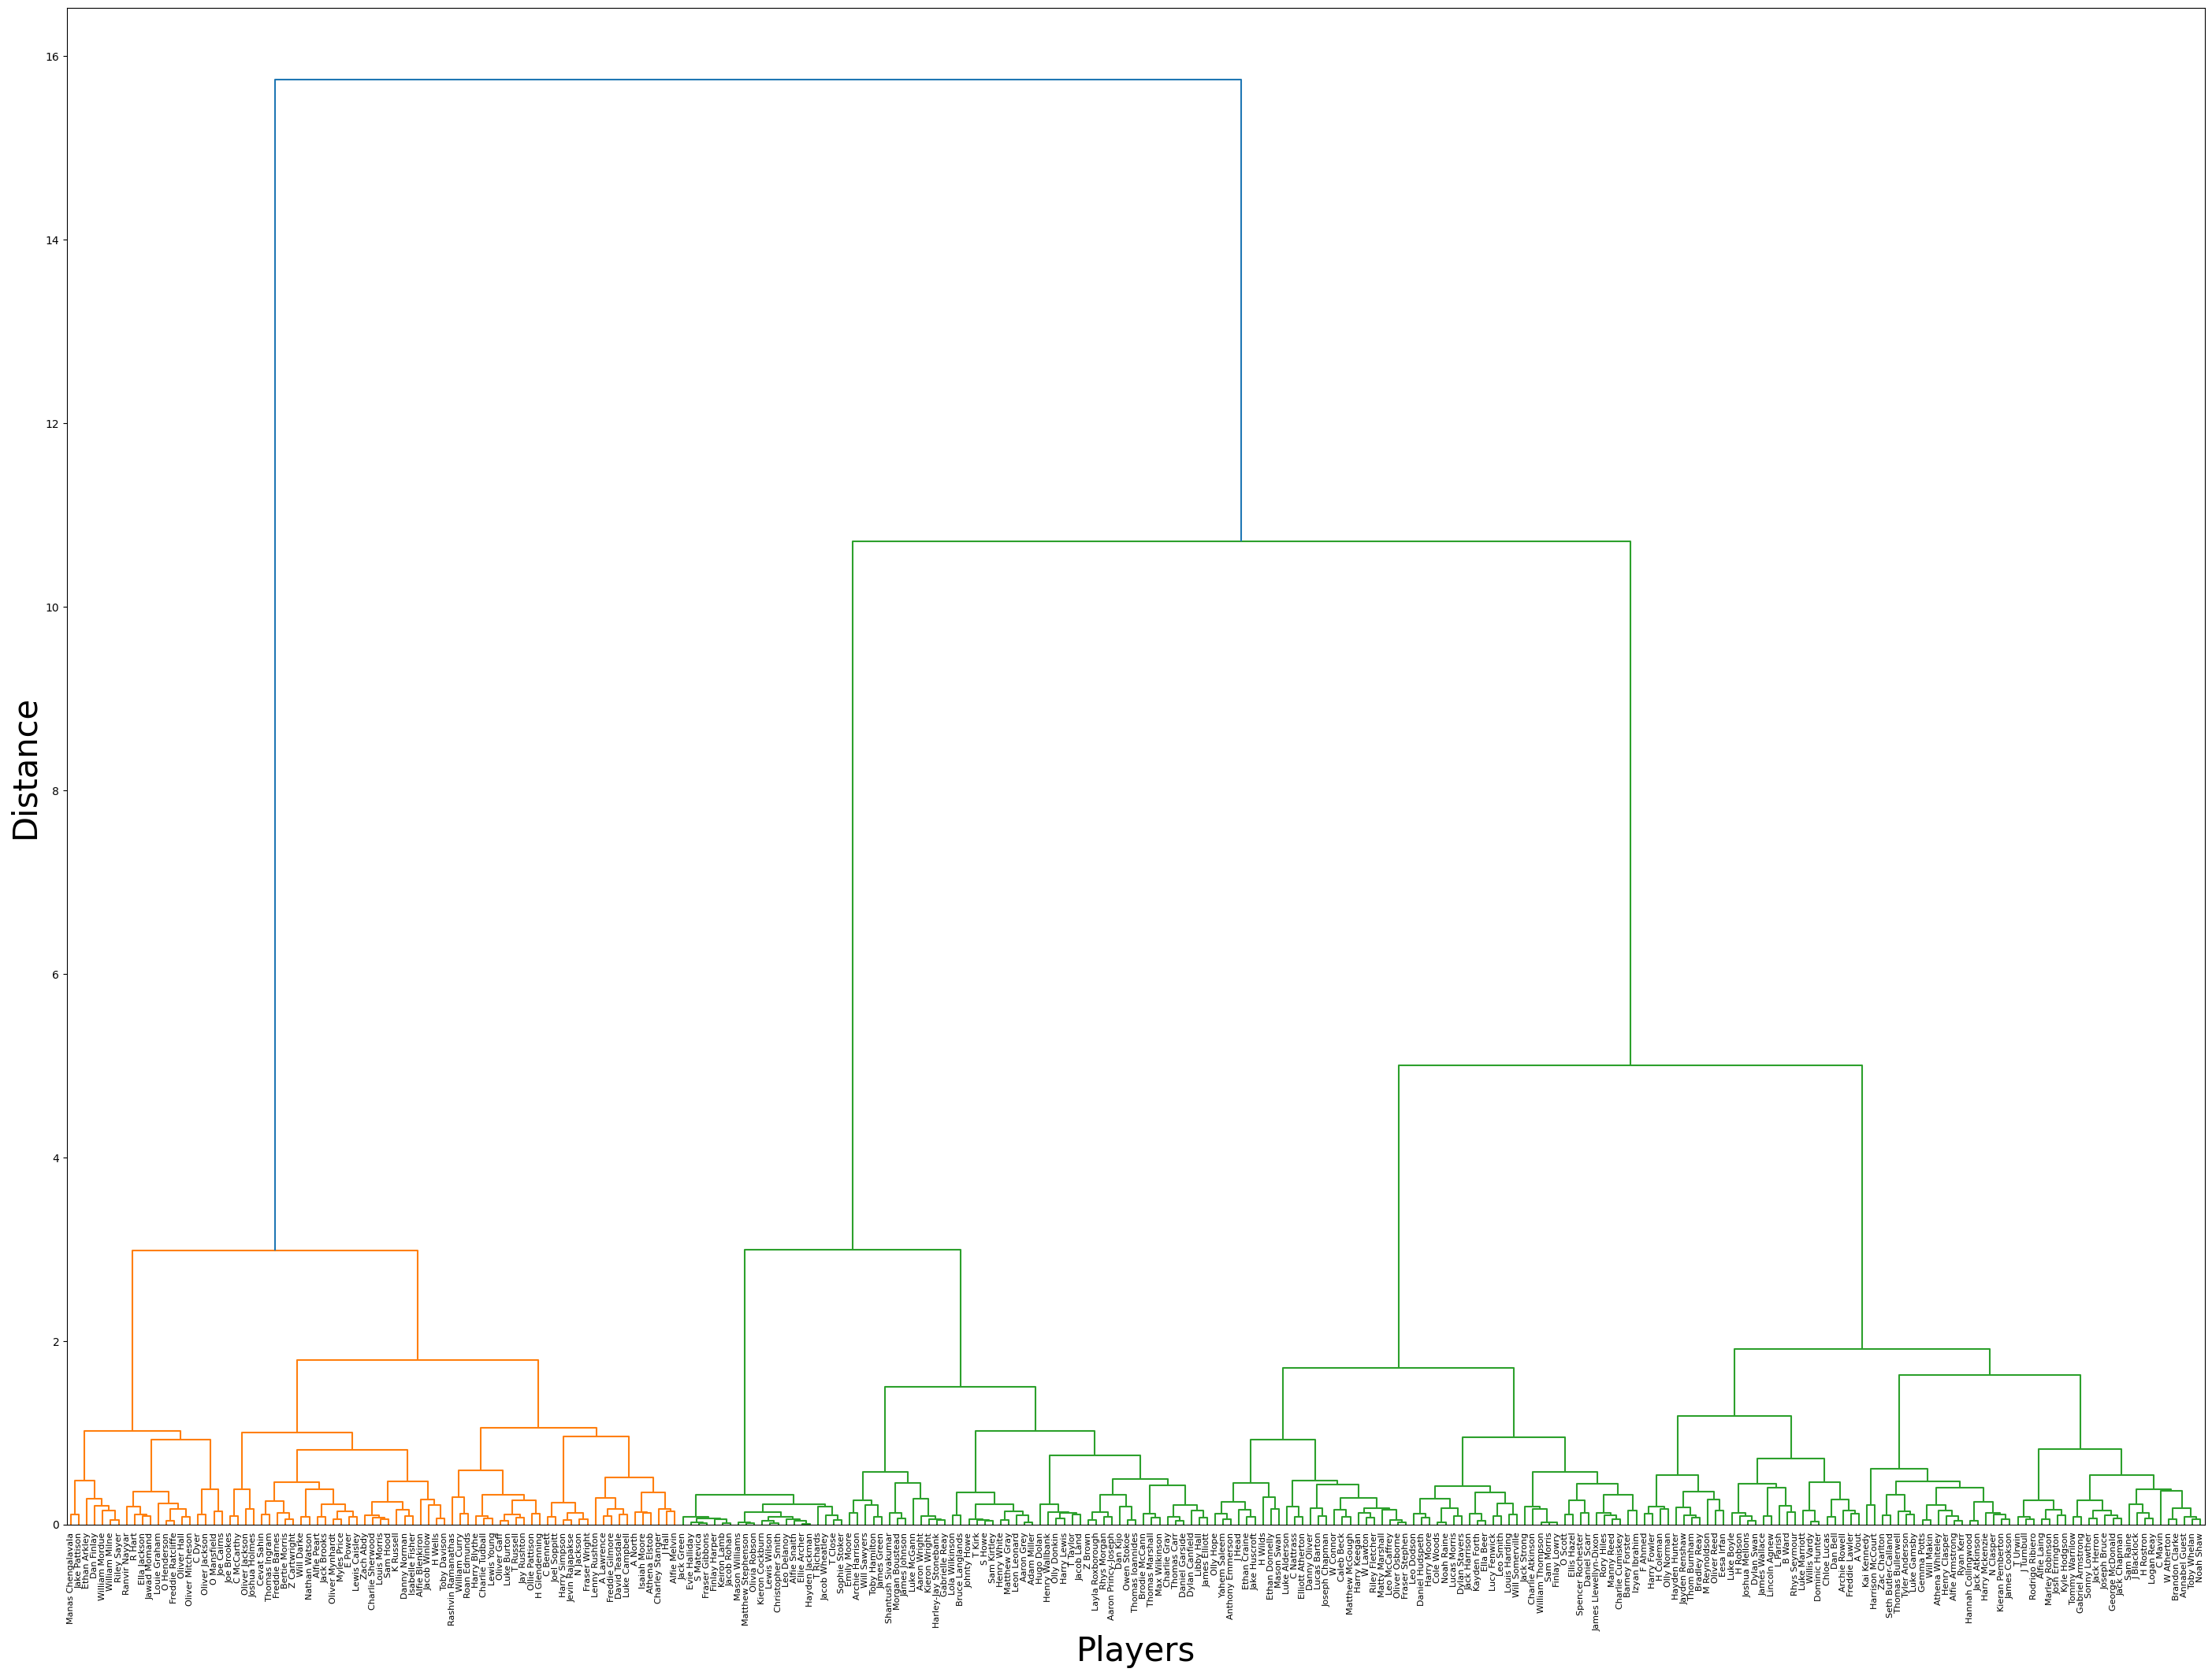

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

h_linkage = linkage(encoded_df, method='ward')

plt.figure(figsize=(35,25))
dendrogram(h_linkage, labels=df['Player'].values, leaf_rotation=90, leaf_font_size=8)
# plt.title('Hierarchical Clustering Dendrgram', fontsize=25)
plt.xlabel('Players', fontsize=30)
plt.ylabel('Distance', fontsize=30)

plt.show()

In [ ]:
h_labels = fcluster(h_linkage, t=6, criterion='distance')

df['Hcluster'] = h_labels
scaled_df['Hcluster'] = h_labels
encoded_df2['Hcluster'] = h_labels


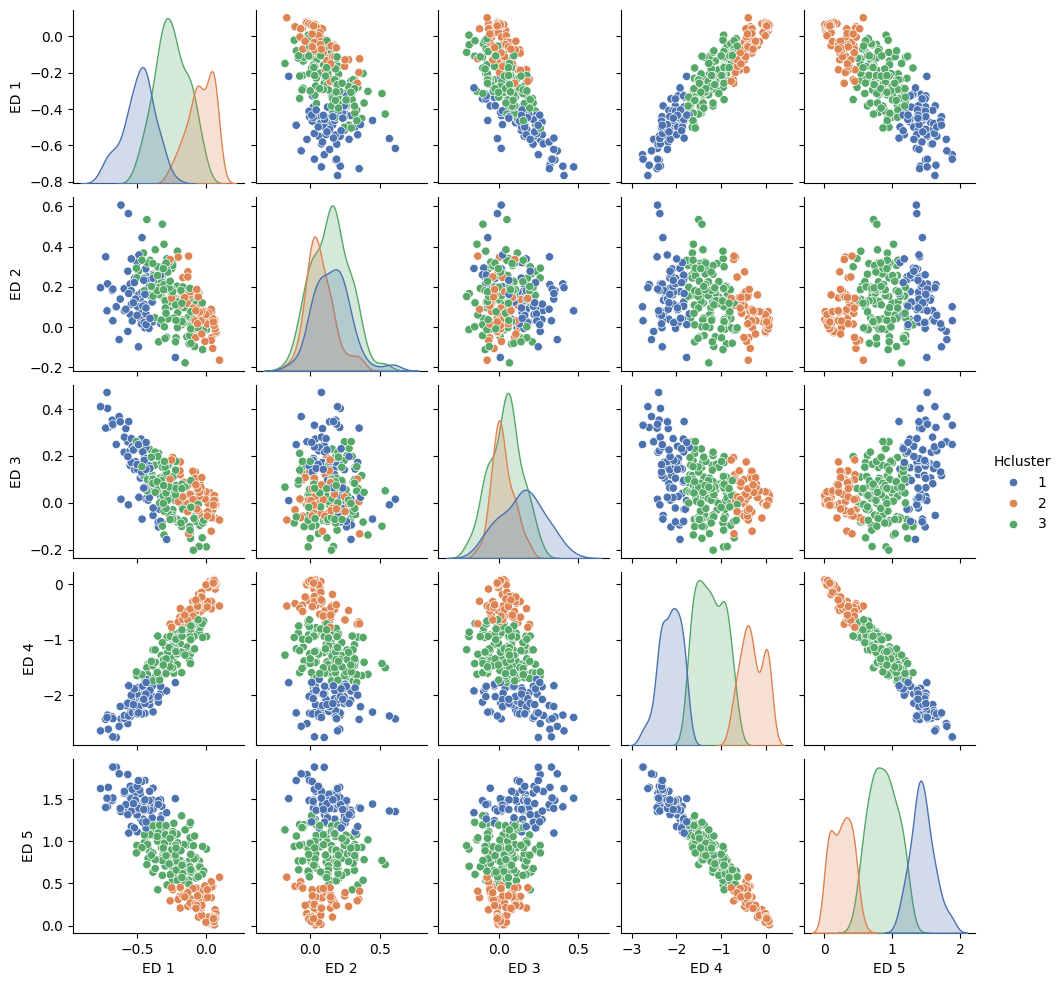

In [ ]:
sns.pairplot(encoded_df2.drop('KCluster',axis=1), hue='Hcluster', palette='deep', diag_kind='kde', height=2, aspect=1)
# plt.suptitle('Pairplot of Encoded Dimensions', y=1.02, fontsize=16)
plt.show()


In [ ]:
hcluster_means_summary = scaled_df.drop('KCluster',axis=1).groupby('Hcluster').mean()
hcluster_means_summary.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Batting Scorecard Analysis/Analysis (Autoencoders)/Hierarchical Cluster Summary (Autoencoder).csv')
hcluster_means_summary

,BFI,BI,FSS,CS,RBWI,BII,FSRatio
Hcluster,,,,,,,
1,0.604550,0.764234,0.639712,0.785263,0.481768,0.801193,0.538466
2,0.301949,0.163444,0.182584,0.157895,0.262915,0.127463,0.054870
3,0.466070,0.498830,0.430993,0.493054,0.399428,0.523140,0.240270


In [ ]:
hcluster_descriptive = scaled_df.drop('KCluster', axis=1).groupby('Hcluster').describe()
hcluster_descriptive.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Batting Scorecard Analysis/Analysis (Autoencoders)/Hierarchical Cluster Descriptive (Autoencoder).csv')
hcluster_descriptive

BFI                                                              \
          count      mean       std       min       25%       50%       75%   
Hcluster                                                                      
1          77.0  0.604550  0.143711  0.276776  0.509221  0.606679  0.701529   
2          67.0  0.301949  0.144117  0.000000  0.201381  0.296423  0.364479   
3         125.0  0.466070  0.173868  0.011410  0.331869  0.452454  0.592738   

                       BI            ...       BII           FSRatio  \
               max  count      mean  ...       75%       max   count   
Hcluster                             ...                               
1         1.000000   77.0  0.764234  ...  0.893052  1.000000    77.0   
2         0.892334   67.0  0.163444  ...  0.222434  0.514602    67.0   
3         0.896471  125.0  0.498830  ...  0.584963  1.000000   125.0   

                                                                                
              mean       std       min       25%       50%       75%       max  
Hcluster                                                                        
1         0.538466  0.214631  0.069812  0.386198  0.547709  0.665132  1.000000  
2         0.054870  0.052616  0.000000  0.000000  0.044592  0.088744  0.218649  
3         0.240270  0.108120  0.044592  0.175764  0.218649  0.303207  0.547709  

[3 rows x 56 columns]

In [ ]:

#The h_labels value will be changed according to which cluster has higher means
h_cluster_1_data = scaled_df.drop('KCluster', axis=1)[h_labels == 1].copy()

h_cluster_1_data['Composite Score'] = (
    h_cluster_1_data['BFI'] * weights['BFI'] +
    h_cluster_1_data['BI'] * weights['BI'] +
    h_cluster_1_data['BII'] * weights['BII'] +
    h_cluster_1_data['CS'] * weights['CS'] +
    h_cluster_1_data['FSS'] * weights['FSS'] +
    h_cluster_1_data['RBWI'] * weights['RBWI'] +
    h_cluster_1_data['FSRatio'] * weights['FSRatio']
)


h_cluster_1_data['Batsman'] = df[h_labels==1]['Player'].values
h_cluster_1_data['Team'] = df[h_labels == 1]['Team'].values


h_ranked_cluster = h_cluster_1_data[['Batsman', 'Team', 'Composite Score']].sort_values(by='Composite Score', ascending=False)


h_ranked_cluster

,Batsman,Team,Composite Score
57,C Dyer,Littletown CC Under 13,4.077043
172,Oliver Jackson,Castle Eden CC Under 13,4.066798
33,Alfie Blenkiron,Bishop Auckland CC Under 13,3.977343
130,C McCarthy,Dawdon Welfare CC Under 13,3.951857
39,Manas Chengalavala,Durham City CC Under 13 Blue,3.930869
...,...,...,...
2,A Lawrence,Tudhoe CC Under 13,2.868016
105,Rashvin Ramanathas,Wearmouth & YAV CC Under 13,2.865725
230,Lenny Rushton,Lanchester CC Under 13,2.702346
221,Luke Campbell,Leadgate CC Under 13,2.693413


In [ ]:
h_ranked_cluster['Rank'] = range(1, len(h_ranked_cluster) + 1)
h_ranked_cluster = h_ranked_cluster[['Rank', 'Batsman', 'Team', 'Composite Score']]
h_ranked_cluster

,Rank,Batsman,Team,Composite Score
57,1,C Dyer,Littletown CC Under 13,4.077043
172,2,Oliver Jackson,Castle Eden CC Under 13,4.066798
33,3,Alfie Blenkiron,Bishop Auckland CC Under 13,3.977343
130,4,C McCarthy,Dawdon Welfare CC Under 13,3.951857
39,5,Manas Chengalavala,Durham City CC Under 13 Blue,3.930869
...,...,...,...,...
2,73,A Lawrence,Tudhoe CC Under 13,2.868016
105,74,Rashvin Ramanathas,Wearmouth & YAV CC Under 13,2.865725
230,75,Lenny Rushton,Lanchester CC Under 13,2.702346
221,76,Luke Campbell,Leadgate CC Under 13,2.693413


In [ ]:
h_ranked_cluster.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Batting Scorecard Analysis/Analysis (Autoencoders)/Player Ranking Hierarchical Cluster 1 (Autoencoder).csv', index=False)


In [ ]:
scaled_df.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Batting Scorecard Analysis/Analysis (Autoencoders)/Scaled Data with cluster (Autoencoder).csv', index=False)
df.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Batting Scorecard Analysis/Analysis (Autoencoders)/Data with cluster (Autoencoder).csv', index=False)
encoded_df2.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Batting Scorecard Analysis/Analysis (Autoencoders)/Encoded Data with cluster (Autoencoder).csv', index=False)